In [2]:
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [3]:
# Path to images and annotations
src = "/kaggle/input/wall-following-robot/sensor_readings_2.csv"

In [4]:
# Open data
with open(src, 'r') as f:
    entries = f.read().split('\n')
    entries = [e.split(',') for e in entries]
    entries = entries[1:-1]

In [5]:
def class_to_ID(cat):
    if cat == 'Move-Forward':
        cat1 = 1
        cat2 = 0
        cat3 = 0
        cat4 = 0
    elif cat == 'Slight-Right-Turn':
        cat1 = 0
        cat2 = 1
        cat3 = 0
        cat4 = 0
    elif cat == 'Sharp-Right-Turn':
        cat1 = 0
        cat2 = 0
        cat3 = 1
        cat4 = 0
    elif cat == 'Slight-Left-Turn':
        cat1 = 0
        cat2 = 0
        cat3 = 0
        cat4 = 1
    else:
        cat1 = 0
        cat2 = 0
        cat3 = 0
        cat4 = 0
    return (cat1,cat2,cat3,cat4)

In [6]:
data_df = pd.DataFrame(
    [
        {
            'SD_front': float(entries[i][0]),
             'SD_left': float(entries[i][1]), 
             'Classes': class_to_ID(entries[i][2])
        } for i in range(len(entries))
    ]
)
#data_df.head()

In [7]:
sen_merg_df = pd.DataFrame([{'Sensor Data': (row['SD_front'],row['SD_left'])} for i, row in data_df.iterrows()])
#sen_merg_df.head()

In [8]:
classes_only = pd.DataFrame([{'Classes': row['Classes']} for i, row in data_df.iterrows()])
#classes_only.head()

In [9]:
input_df = classes_only.join(sen_merg_df)
#input_df.head()

In [10]:
sensor_df = data_df[['SD_front','SD_left']]

In [11]:
means = [sensor_df[col].mean() for col in sensor_df]
std_devs = [sensor_df[col].std() for col in sensor_df]
#means, std_devs

In [12]:
def sensor_scaler(tensor):
    return (tensor-means)/std_devs

In [13]:
input_df = input_df.sample(frac=1)

train_perc, test_perc = 0.5, 0.2
dsize = len(input_df)
first_div = int(dsize*train_perc)
second_div = first_div + int(dsize*test_perc)

train_df, test_df, val_df = input_df[:first_div], input_df[first_div:second_div], input_df[second_div:]

In [14]:
def get_xy(df):
    x, y = [], []
    for i, row in df.iterrows():
        x.append(row['Sensor Data'])
        y.append(row['Classes'])
    x, y = np.array(x), np.array(y)
    return x, y

In [15]:
X_train, Y_train = get_xy(train_df)
X_test, Y_test = get_xy(test_df)
X_val, Y_val = get_xy(val_df)

In [16]:
def lin_model(inputs):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [17]:
def nonlin_model(inputs):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dense(128, activation = 'relu')(x)
    x = keras.layers.Dense(64, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [18]:
bat_size = 64

# Excersise 1; Linear V.S. Non-linear

In [19]:
X = keras.Input(shape=((2,)), batch_size = bat_size)
model = lin_model(X)
optimiser = keras.optimizers.SGD(learning_rate=0.01,
                                 momentum=0.9,
                                 global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 8s 11ms/step - loss: 0.8559 - categorical_accuracy: 0.6663 - val_loss: 0.5893 - val_categorical_accuracy: 0.7679
Epoch 2/5
86/86 [==============================] - 1s 7ms/step - loss: 0.4582 - categorical_accuracy: 0.8130 - val_loss: 0.5136 - val_categorical_accuracy: 0.7642
Epoch 3/5
86/86 [==============================] - 0s 6ms/step - loss: 0.3786 - categorical_accuracy: 0.8511 - val_loss: 0.5881 - val_categorical_accuracy: 0.7978
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3838 - categorical_accuracy: 0.8610 - val_loss: 0.3293 - val_categorical_accuracy: 0.8949
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 0.3069 - categorical_accuracy: 0.8830 - val_loss: 0.3378 - val_categorical_accuracy: 0.8363


> It can be noticed that the linear model *appears* to be doing better, but as it reaches the 5th epoch, the model's accuracy begins to drop again.
> Whereas, the non-linear model appears to undergo a more stable growth in its accuracy.

In [20]:
X = keras.Input(shape=((2,)), batch_size = bat_size)
model = nonlin_model(X)
optimiser = keras.optimizers.SGD(learning_rate=0.001,
                                 momentum=0.9,
                                 global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 7ms/step - loss: 1.2671 - categorical_accuracy: 0.3971 - val_loss: 1.1897 - val_categorical_accuracy: 0.4130
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1451 - categorical_accuracy: 0.5222 - val_loss: 1.1144 - val_categorical_accuracy: 0.6494
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0798 - categorical_accuracy: 0.6850 - val_loss: 1.0594 - val_categorical_accuracy: 0.6958
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0199 - categorical_accuracy: 0.7030 - val_loss: 0.9983 - val_categorical_accuracy: 0.6946
Epoch 5/5
86/86 [==============================] - 1s 8ms/step - loss: 0.9579 - categorical_accuracy: 0.6960 - val_loss: 0.9395 - val_categorical_accuracy: 0.6866


# Excercise 2; optimising number of hidden 'units'

In [21]:
def MLP(inputs, num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens = num_hiddens//2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

> Powers of 2 (eg, 2^3, 2^9, 2^12) seem to offer a good trade off.

> with the MLP model I have defined above, the most optimal values appears to be around the value 2^8.
> results of testing shown below:

In [22]:
X = keras.Input(shape=((2,)), batch_size = bat_size)

In [23]:
model = MLP(X, 2**10)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 10ms/step - loss: 1.2801 - categorical_accuracy: 0.3726 - val_loss: 1.1958 - val_categorical_accuracy: 0.4233
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1593 - categorical_accuracy: 0.4899 - val_loss: 1.1319 - val_categorical_accuracy: 0.6335
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1037 - categorical_accuracy: 0.6692 - val_loss: 1.0848 - val_categorical_accuracy: 0.7153
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0552 - categorical_accuracy: 0.7213 - val_loss: 1.0399 - val_categorical_accuracy: 0.6976
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0087 - categorical_accuracy: 0.6978 - val_loss: 0.9949 - val_categorical_accuracy: 0.6940


In [24]:
model = MLP(X, 2**9)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 9ms/step - loss: 1.2828 - categorical_accuracy: 0.3693 - val_loss: 1.1965 - val_categorical_accuracy: 0.4276
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1589 - categorical_accuracy: 0.5075 - val_loss: 1.1288 - val_categorical_accuracy: 0.5919
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1019 - categorical_accuracy: 0.6315 - val_loss: 1.0813 - val_categorical_accuracy: 0.7104
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0537 - categorical_accuracy: 0.7187 - val_loss: 1.0356 - val_categorical_accuracy: 0.7031
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0063 - categorical_accuracy: 0.7088 - val_loss: 0.9901 - val_categorical_accuracy: 0.6891


In [25]:
model = MLP(X, 2**8)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 7ms/step - loss: 1.2813 - categorical_accuracy: 0.3429 - val_loss: 1.1889 - val_categorical_accuracy: 0.4130
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1569 - categorical_accuracy: 0.4932 - val_loss: 1.1314 - val_categorical_accuracy: 0.6164
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1042 - categorical_accuracy: 0.6751 - val_loss: 1.0863 - val_categorical_accuracy: 0.7098
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0566 - categorical_accuracy: 0.7176 - val_loss: 1.0405 - val_categorical_accuracy: 0.7037
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0105 - categorical_accuracy: 0.7136 - val_loss: 0.9972 - val_categorical_accuracy: 0.6860


In [26]:
model = MLP(X, 2**7)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 7ms/step - loss: 1.2676 - categorical_accuracy: 0.4323 - val_loss: 1.2116 - val_categorical_accuracy: 0.4172
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1867 - categorical_accuracy: 0.4367 - val_loss: 1.1655 - val_categorical_accuracy: 0.6109
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1447 - categorical_accuracy: 0.6384 - val_loss: 1.1283 - val_categorical_accuracy: 0.6487
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1043 - categorical_accuracy: 0.7011 - val_loss: 1.0868 - val_categorical_accuracy: 0.7056
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0614 - categorical_accuracy: 0.7085 - val_loss: 1.0472 - val_categorical_accuracy: 0.7031


In [27]:
losses, accs = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = MLP(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train)
    losses.append(loss)
    accs.append(accuracy)

86/86 [==============================] - 0s 3ms/step - loss: 1.3617 - categorical_accuracy: 0.3927


<function matplotlib.pyplot.show(close=None, block=None)>

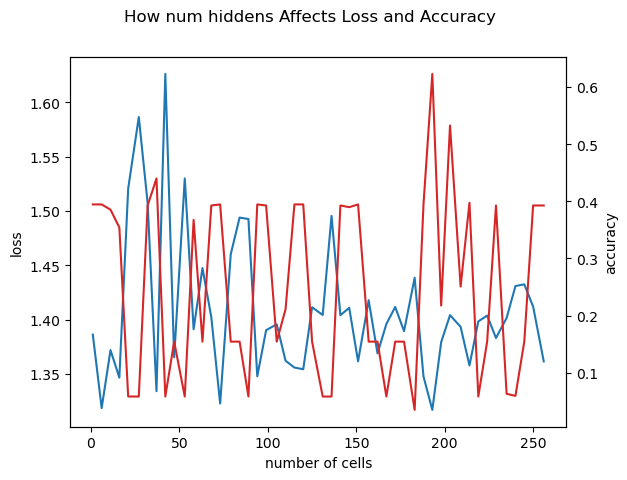

In [28]:
fig, ax1 = plt.subplots()
fig.suptitle("How num hiddens Affects Loss and Accuracy")
ax1.plot(cells, losses)
ax2 = ax1.twinx()
ax2.plot(cells, accs, color = 'tab:red')
ax1.set(xlabel = 'number of cells')
ax1.set(ylabel = 'loss'), ax2.set(ylabel = 'accuracy')
plt.show

Having reviewed a couple editions of this graph, I get the impression that the performance is largely an unstable thing, and very likely depends on what data is batched into the network for the evaluation. However, what I can say is that after 200 hidden cells, the performance of the network seems to start gaining more stability.
If kaggle allowed for a greater amount of data allocation, I'd test into further ranges, reaching up to 2^10, or even 2^12 as the max point.

# Excersise 3; additional layers

what happens if we keep adding more layers to the network?

In [29]:
def MLP_2deep(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

def MLP_3deep(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

def MLP_4deep(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

def MLP_5deep(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [30]:
model = MLP_2deep(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 7ms/step - loss: 1.2891 - categorical_accuracy: 0.5226 - val_loss: 1.2034 - val_categorical_accuracy: 0.5455
Epoch 2/5
86/86 [==============================] - 0s 6ms/step - loss: 1.1604 - categorical_accuracy: 0.5640 - val_loss: 1.1282 - val_categorical_accuracy: 0.6420
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0983 - categorical_accuracy: 0.6733 - val_loss: 1.0786 - val_categorical_accuracy: 0.7068
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0493 - categorical_accuracy: 0.7125 - val_loss: 1.0337 - val_categorical_accuracy: 0.7025
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0040 - categorical_accuracy: 0.7030 - val_loss: 0.9913 - val_categorical_accuracy: 0.6897


In [32]:
losses_2, accs_2 = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = MLP_2deep(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_2.append(loss)
    accs_2.append(accuracy)

In [33]:
model = MLP_3deep(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 1s 8ms/step - loss: 1.2899 - categorical_accuracy: 0.5108 - val_loss: 1.2111 - val_categorical_accuracy: 0.5199
Epoch 2/5
86/86 [==============================] - 1s 8ms/step - loss: 1.1598 - categorical_accuracy: 0.5570 - val_loss: 1.1191 - val_categorical_accuracy: 0.6304
Epoch 3/5
86/86 [==============================] - 1s 9ms/step - loss: 1.0791 - categorical_accuracy: 0.6993 - val_loss: 1.0509 - val_categorical_accuracy: 0.7117
Epoch 4/5
86/86 [==============================] - 1s 7ms/step - loss: 1.0083 - categorical_accuracy: 0.7107 - val_loss: 0.9841 - val_categorical_accuracy: 0.6915
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 0.9383 - categorical_accuracy: 0.7011 - val_loss: 0.9216 - val_categorical_accuracy: 0.6738


In [35]:
losses_3, accs_3 = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = MLP_3deep(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_3.append(loss)
    accs_3.append(accuracy)

In [36]:
model = MLP_4deep(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 8ms/step - loss: 1.3152 - categorical_accuracy: 0.3616 - val_loss: 1.2502 - val_categorical_accuracy: 0.4130
Epoch 2/5
86/86 [==============================] - 0s 6ms/step - loss: 1.2074 - categorical_accuracy: 0.3953 - val_loss: 1.1678 - val_categorical_accuracy: 0.4203
Epoch 3/5
86/86 [==============================] - 1s 7ms/step - loss: 1.1378 - categorical_accuracy: 0.4976 - val_loss: 1.1112 - val_categorical_accuracy: 0.6121
Epoch 4/5
86/86 [==============================] - 0s 6ms/step - loss: 1.0825 - categorical_accuracy: 0.7077 - val_loss: 1.0579 - val_categorical_accuracy: 0.7440
Epoch 5/5
86/86 [==============================] - 1s 8ms/step - loss: 1.0239 - categorical_accuracy: 0.7341 - val_loss: 1.0005 - val_categorical_accuracy: 0.7068


In [37]:
losses_4, accs_4 = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = MLP_4deep(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_4.append(loss)
    accs_4.append(accuracy)

In [38]:
model = MLP_5deep(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 8ms/step - loss: 1.3198 - categorical_accuracy: 0.3927 - val_loss: 1.2661 - val_categorical_accuracy: 0.3751
Epoch 2/5
86/86 [==============================] - 1s 6ms/step - loss: 1.2280 - categorical_accuracy: 0.4184 - val_loss: 1.2076 - val_categorical_accuracy: 0.4875
Epoch 3/5
86/86 [==============================] - 1s 6ms/step - loss: 1.1815 - categorical_accuracy: 0.6095 - val_loss: 1.1714 - val_categorical_accuracy: 0.6659
Epoch 4/5
86/86 [==============================] - 0s 6ms/step - loss: 1.1467 - categorical_accuracy: 0.7070 - val_loss: 1.1351 - val_categorical_accuracy: 0.6775
Epoch 5/5
86/86 [==============================] - 0s 6ms/step - loss: 1.1062 - categorical_accuracy: 0.6784 - val_loss: 1.0927 - val_categorical_accuracy: 0.6707


In [39]:
losses_5, accs_5 = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = MLP_5deep(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_5.append(loss)
    accs_5.append(accuracy)

In [40]:
loss_sets = [losses_2, losses_3, losses_4, losses_5]
acc_sets = [accs_2, accs_3, accs_4, accs_5]

<function matplotlib.pyplot.show(close=None, block=None)>

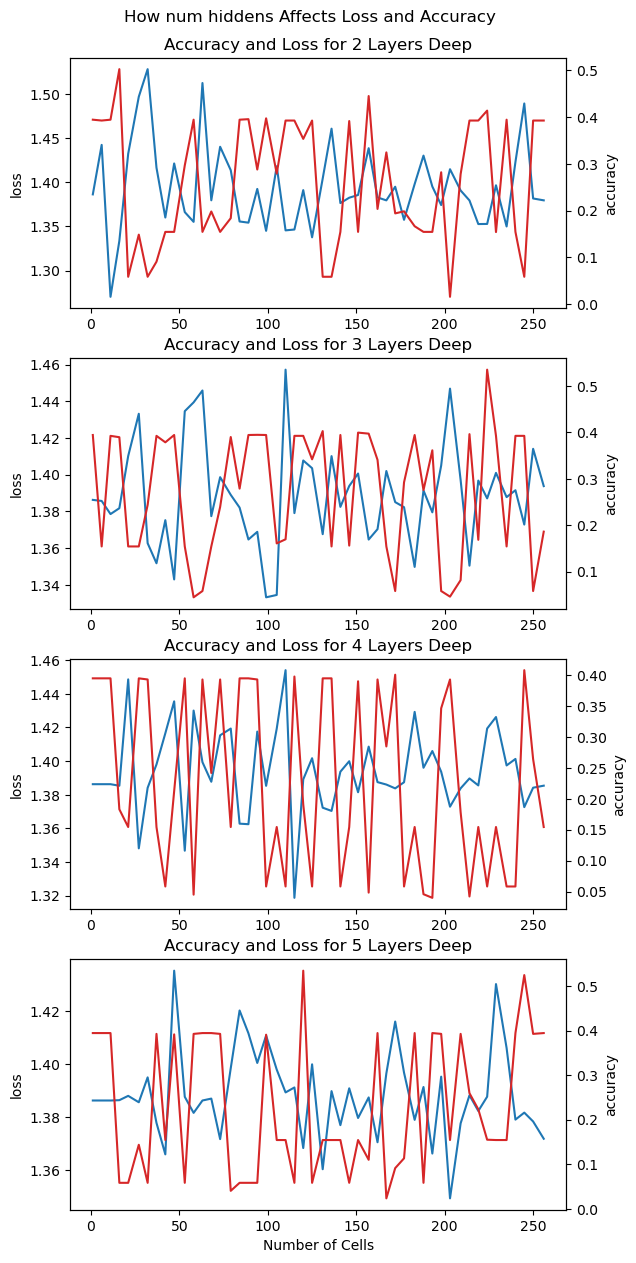

In [70]:
fig, ax1 = plt.subplots(4,1)
fig.suptitle("How num hiddens Affects Loss and Accuracy", y = 2.5)
for i in range(4):
    ax1[i].plot(cells, loss_sets[i]), ax1[i].set_title(f"Accuracy and Loss for {i+2} Layers Deep")
    ax2 = ax1[i].twinx()
    ax2.plot(cells, acc_sets[i], color = 'tab:red')
    #ax1[i].set(xlabel = 'number of cells')
    ax1[i].set(ylabel = 'loss'), ax2.set(ylabel = 'accuracy')
ax1[3].set(xlabel = 'Number of Cells')
plt.subplots_adjust(bottom = 0.0001, top = 2.4)
plt.show

# Exercise 4; perceptrons invading networks

as the subtitle for this section implies, adding a single nueron deep layer to a network before the output layer creates the issue of creating a perceptron that will bottleneck all of the predictions. This will cause the accuracy to suffer greatly.

In [73]:
def lin_5deep_cutoff(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens)(x)#1
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens)(x)#2
    num_hiddens/=2
    x = keras.layers.Dense(1)(x)#3
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens)(x)#4
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens)(x)#5
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

def nonlin_5deep_cutoff(inputs,num_hiddens):
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#1
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#2
    num_hiddens/=2
    x = keras.layers.Dense(1, activation = 'relu')(x)#3
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#4
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#5
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [ ]:
model = lin_5deep_cutoff(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

In [74]:
losses_lin_5_cutoff, accs_lin_5_cutoff = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = lin_5deep_cutoff(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_lin_5_cutoff.append(loss)
    accs_lin_5_cutoff.append(accuracy)

In [ ]:
model = nonlin_5deep_cutoff(X,256)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )

model.fit(x = X_train, y = Y_train, validation_data=(X_val,Y_val), epochs = 5)

In [75]:
losses_nonlin_5_cutoff, accs_nonlin_5_cutoff = [],[]
start, stop = 1, 256
cells = np.linspace(start, stop, dtype = np.int32)
for i in cells:
    model = lin_5deep_cutoff(X, i)
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_nonlin_5_cutoff.append(loss)
    accs_nonlin_5_cutoff.append(accuracy)

In [76]:
cutoff_losses = [losses_lin_5_cutoff, losses_nonlin_5_cutoff]
cutoff_accs = [accs_lin_5_cutoff, accs_nonlin_5_cutoff]

<function matplotlib.pyplot.show(close=None, block=None)>

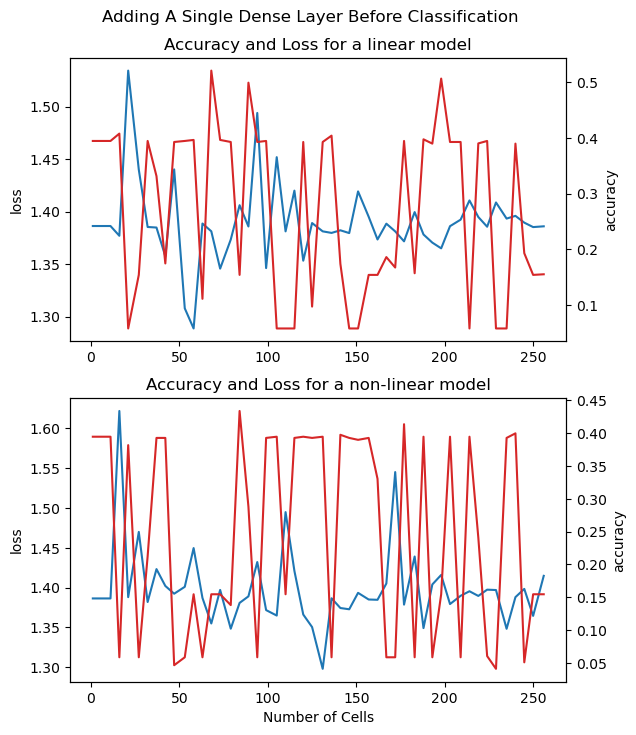

In [82]:
fig, ax1 = plt.subplots(2,1)
fig.suptitle("Adding A Single Dense Layer Before Classification", y = 1.5)
for i in range(2):
    ax1[i].plot(cells, cutoff_losses[i])
    ax2 = ax1[i].twinx()
    ax2.plot(cells, cutoff_accs[i], color = 'tab:red')
    #ax1[i].set(xlabel = 'number of cells')
    ax1[i].set(ylabel = 'loss'), ax2.set(ylabel = 'accuracy')
ax1[0].set_title("Accuracy and Loss for a linear model"), ax1[1].set_title("Accuracy and Loss for a non-linear model")
ax1[1].set(xlabel = 'Number of Cells')
plt.subplots_adjust(bottom = 0.1, top = 1.4)
plt.show

There is a clear and marked reduction in the performance of the networks, the non-linear model dropping to below 45% —from roughly 68~71%— and the linear model is reduced to an accuracy of mostly less than 50%. Clearly, adding a single dense layer in the middle of a network interrupts the network's feature extraction, causing networks to reduce in effectiveness.

# Exercise 5; Change across learning rates and relation to epochs

In [83]:
def MLP_5deep_set(inputs):
    x = keras.layers.Flatten()(inputs)
    num_hiddens = 256
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#1
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#2
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#3
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#4
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = 'relu')(x)#5
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [92]:
model = MLP_5deep_set(X)
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )
model.fit(x = X_train, y = Y_train, validation_data = (X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 8ms/step - loss: 1.3187 - categorical_accuracy: 0.3176 - val_loss: 1.2601 - val_categorical_accuracy: 0.4130
Epoch 2/5
86/86 [==============================] - 0s 6ms/step - loss: 1.2145 - categorical_accuracy: 0.3957 - val_loss: 1.1755 - val_categorical_accuracy: 0.4197
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1355 - categorical_accuracy: 0.5127 - val_loss: 1.1045 - val_categorical_accuracy: 0.6500
Epoch 4/5
86/86 [==============================] - 0s 6ms/step - loss: 1.0640 - categorical_accuracy: 0.7103 - val_loss: 1.0353 - val_categorical_accuracy: 0.7269
Epoch 5/5
86/86 [==============================] - 0s 6ms/step - loss: 0.9925 - categorical_accuracy: 0.7275 - val_loss: 0.9713 - val_categorical_accuracy: 0.7135


In [89]:
losses_5set, accs_5set = [],[]
start, stop = 0, 1
lr = np.linspace(start, stop, dtype = np.float32)
for i in lr:
    model = MLP_5deep_set(X)
    optimiser = keras.optimizers.SGD(learning_rate=i,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )

    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    losses_5set.append(loss)
    accs_5set.append(accuracy)

<function matplotlib.pyplot.show(close=None, block=None)>

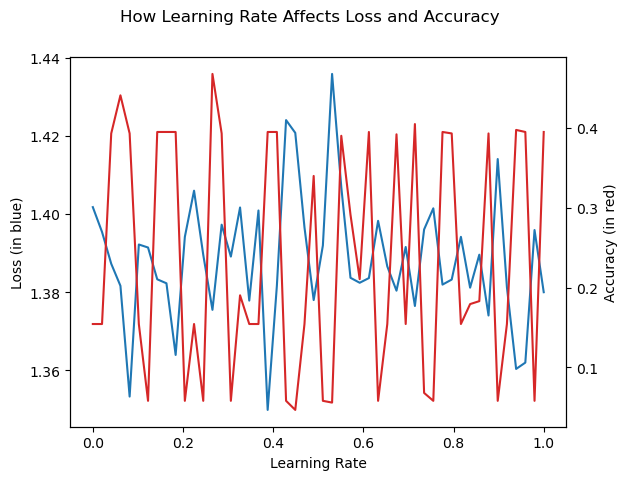

In [91]:
fig, ax1 = plt.subplots()
fig.suptitle("How Learning Rate Affects Loss and Accuracy")
ax1.plot(lr, losses_5set)
ax2 = ax1.twinx()
ax2.plot(lr, accs_5set, color = 'tab:red')
ax1.set(xlabel = 'Learning Rate')
ax1.set(ylabel = 'Loss (in blue)'), ax2.set(ylabel = 'Accuracy (in red)')
plt.show

The effects of changing the learning rate seems to vary quite a bit, but generally speaking, it seems that the lower values of learning rate will provide smaller loss values to match with simillar to better accuracies

# Exercise 6; playing with activation functions

In [93]:
def MLP_var_activ(inputs, activ):
    x = keras.layers.Flatten()(inputs)
    num_hiddens = 256
    x = keras.layers.Dense(num_hiddens, activation = activ)(x)#1
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = activ)(x)#2
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = activ)(x)#3
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = activ)(x)#4
    num_hiddens/=2
    x = keras.layers.Dense(num_hiddens, activation = activ)(x)#5
    x = keras.layers.Dense(4, activation = 'softmax')(x)
    return keras.Model(inputs = inputs, outputs = x)

In [95]:
model = MLP_var_activ(X, 'relu')
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )
model.fit(x = X_train, y = Y_train, validation_data = (X_val,Y_val), epochs = 5)


Epoch 1/5
86/86 [==============================] - 2s 7ms/step - loss: 1.3419 - categorical_accuracy: 0.3660 - val_loss: 1.2872 - val_categorical_accuracy: 0.5736
Epoch 2/5
86/86 [==============================] - 0s 6ms/step - loss: 1.2436 - categorical_accuracy: 0.5937 - val_loss: 1.2024 - val_categorical_accuracy: 0.6194
Epoch 3/5
86/86 [==============================] - 0s 5ms/step - loss: 1.1583 - categorical_accuracy: 0.6289 - val_loss: 1.1162 - val_categorical_accuracy: 0.6579
Epoch 4/5
86/86 [==============================] - 0s 6ms/step - loss: 1.0639 - categorical_accuracy: 0.6725 - val_loss: 1.0172 - val_categorical_accuracy: 0.7001
Epoch 5/5
86/86 [==============================] - 0s 5ms/step - loss: 0.9589 - categorical_accuracy: 0.7044 - val_loss: 0.9175 - val_categorical_accuracy: 0.7007


In [96]:
model = MLP_var_activ(X, 'tanh')
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )
model.fit(x = X_train, y = Y_train, validation_data = (X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 8ms/step - loss: 1.2081 - categorical_accuracy: 0.5372 - val_loss: 1.0990 - val_categorical_accuracy: 0.6964
Epoch 2/5
86/86 [==============================] - 0s 5ms/step - loss: 1.0229 - categorical_accuracy: 0.6887 - val_loss: 0.9608 - val_categorical_accuracy: 0.6964
Epoch 3/5
86/86 [==============================] - 0s 6ms/step - loss: 0.8838 - categorical_accuracy: 0.6975 - val_loss: 0.8482 - val_categorical_accuracy: 0.6787
Epoch 4/5
86/86 [==============================] - 0s 5ms/step - loss: 0.7788 - categorical_accuracy: 0.7081 - val_loss: 0.7612 - val_categorical_accuracy: 0.7043
Epoch 5/5
86/86 [==============================] - 0s 6ms/step - loss: 0.7068 - categorical_accuracy: 0.7217 - val_loss: 0.6986 - val_categorical_accuracy: 0.7178


In [97]:
model = MLP_var_activ(X, 'sigmoid')
optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
model.compile(
    loss="categorical_crossentropy",
    optimizer= optimiser,
    metrics= [keras.metrics.CategoricalAccuracy()] )
model.fit(x = X_train, y = Y_train, validation_data = (X_val,Y_val), epochs = 5)

Epoch 1/5
86/86 [==============================] - 2s 7ms/step - loss: 1.2627 - categorical_accuracy: 0.3946 - val_loss: 1.2103 - val_categorical_accuracy: 0.4130
Epoch 2/5
86/86 [==============================] - 1s 6ms/step - loss: 1.2023 - categorical_accuracy: 0.3854 - val_loss: 1.1989 - val_categorical_accuracy: 0.4130
Epoch 3/5
86/86 [==============================] - 0s 6ms/step - loss: 1.1930 - categorical_accuracy: 0.3916 - val_loss: 1.1966 - val_categorical_accuracy: 0.4130
Epoch 4/5
86/86 [==============================] - 1s 6ms/step - loss: 1.1907 - categorical_accuracy: 0.3913 - val_loss: 1.1970 - val_categorical_accuracy: 0.3751
Epoch 5/5
86/86 [==============================] - 0s 6ms/step - loss: 1.1892 - categorical_accuracy: 0.3949 - val_loss: 1.1962 - val_categorical_accuracy: 0.4130


In [155]:
model = MLP_var_activ(X, 'relu')
loss_1, accuracy_1 = [],[]
for i in range(50):
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )
    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    loss_1.append(loss)
    accuracy_1.append(accuracy)
loss_1 = tf.convert_to_tensor(loss_1)
loss_1 = tf.math.reduce_mean(loss_1)
accuracy_1 = tf.convert_to_tensor(accuracy_1)
accuracy_1 = tf.math.reduce_mean(accuracy_1)

In [156]:
model = MLP_var_activ(X, 'tanh')
loss_2, accuracy_2 = [],[]
for i in range(50):
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )
    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    loss_2.append(loss)
    accuracy_2.append(accuracy)
loss_2 = tf.convert_to_tensor(loss_2)
loss_2 = tf.math.reduce_mean(loss_2)
accuracy_2 = tf.convert_to_tensor(accuracy_2)
accuracy_2 = tf.math.reduce_mean(accuracy_2)

In [158]:
model = MLP_var_activ(X, 'sigmoid')
loss_3, accuracy_3 = [],[]
for i in range(50):
    optimiser = keras.optimizers.SGD(learning_rate=0.001,momentum=0.9, global_clipnorm=10.0 )
    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimiser,
        metrics= [keras.metrics.CategoricalAccuracy()] )
    loss, accuracy = model.evaluate(x = X_train, y = Y_train, verbose = 0)
    loss_3.append(loss)
    accuracy_3.append(accuracy)
loss_3 = tf.convert_to_tensor(loss_3)
loss_3 = tf.math.reduce_mean(loss_3)
accuracy_3 = tf.convert_to_tensor(accuracy_3)
accuracy_3 = tf.math.reduce_mean(accuracy_3)

In [159]:
loss_1, loss_2, loss_3 = loss_1.numpy(), loss_2.numpy(), loss_3.numpy()
accuracy_1, accuracy_2, accuracy_3 = accuracy_1.numpy(), accuracy_2.numpy(), accuracy_3.numpy()

In [160]:
bargraph_loss = {'ReLU': loss_1, 'TanH': loss_2, 'Sigmoid': loss_3}
bargraph_acc = {'ReLU': accuracy_1, 'TanH': accuracy_2, 'Sigmoid': accuracy_3}
activs = bargraph_loss.keys()
losses_activ = bargraph_loss.values()
accuracy_activ = bargraph_acc.values()

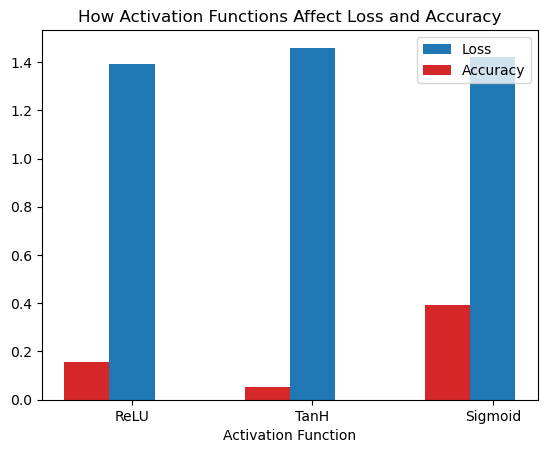

In [161]:
bw = 0.25

fig = plt.subplots()
plt.title("How Activation Functions Affect Loss and Accuracy")
plt.bar(activs, losses_activ, width = bw, label = 'Loss')
plt.bar([-bw,1-bw, 2-bw], accuracy_activ, color = 'tab:red', width = bw, label = 'Accuracy')
plt.xlabel('Activation Function')
#ax1.set(ylabel = 'Loss (in blue)'), ax2.set(ylabel = 'Accuracy (in red)')
plt.legend()
plt.show()

After having run the code a couple of times, it seems that though the loss stays relatively the same, the accuracy seems to change from iterration to iteration. Even after changing the code to iterate through each model 50 times.
However, I seem to be getting the impression that the Sigmoid function might serve better for a smaller classification network like my own?

# Exercise 7; N X M gradient

My estimation is that the gradient will retain the shape of NxM given by F(N,M)

In [171]:
from math import pi

In [193]:
N , M = np.random.randint(1,420), np.random.randint(1,420)
x = tf.Variable( [np.linspace(0,2*pi, num = M) for i in range(N)] )
with tf.GradientTape() as tape:
    y = tf.math.sin(x)
    #print(f"sin(x) for 0=< x <= 2π:\n{y[0].numpy}\ncos(x) for 0=< x <= 2π:\n{y[1].numpy}")
    dy_dx = tape.gradient(y,x)
    #print(f"F'([sin(x), cos(x)]) for 0=< x <= 2π:\n{dy_dx.numpy}")
print(f"Dimensions: N = {N}, M = {M}\nInput Shape: {x.numpy().shape}\tOutput Shape: {y.numpy().shape}\nGradient Shape: {dy_dx.numpy().shape}")

Dimensions: N = 91, M = 266
Input Shape: (91, 266)	Output Shape: (91, 266)
Gradient Shape: (91, 266)


This proves my theory to be correct, the gradient will generally match the dimensionality of any scalar function